In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:

weirs = {
    "name": ["CSO_1", "CSO_10", "CSO_2", "CSO_20", "CSO_21"],
    "crest_level": [10.9, 10.62, 10.27, 10.79, 12.17],
    "discharge_coef": [1.34657, 1.34657, 1.34657, 1.34657, 1.34657],
    "length": [17, 19.8, 21.8, 9.5, 11.25],
}

pumps = {
    "name": [
        "WWWTP_inlet",
        "P_10_1",
        "P_2_1",
        "CSO_pump_2",
        "P_20_2",
        "P_21_2",
        "CSO_pump_21",
    ],
    "switch_on": [9.47, 8.61, 8.04, 9.14, 10.26, 10.29, 11.11],
    "switch_off": [9.17, 8.51, 7.89, 8.99, 7.89, 8.99, 10.11, 9.79, 10.91],
    "max_setpoint": [1.167, 0.694, 0.5, 0.015, 0.0417, 0.5556, 0.0278],
}


In [ ]:


def main():
    pump_data = pd.read_csv(
        "RTC/data/Dean Town Pump Data.csv",
        delimiter=",",
        index_col=0,
        parse_dates=True,
        names=pumps["name"],
        skiprows=1,
    )
    head_data = pd.read_csv(
        "RTC/data/Dean Town Head Data.csv",
        delimiter=",",
        index_col=0,
        parse_dates=True,
        names=weirs["name"],
        skiprows=1,
    )

    flows = []
    for i, name in enumerate(weirs["name"]):
        # flows[name] = weir_formula(
        #     weirs["discharge_coef"][i],
        #     weirs["length"][i],
        #     head_data.loc[head_data[name] > weirs["crest_level"][i], name],
        #     weirs["crest_level"][i],
        # )
        flows.append(
            np.array(
                [
                    weir_formula(
                        1.34657, weirs["length"][i], j, weirs["crest_level"][i]
                    )
                    for j in head_data[name].values
                    if j > weirs["crest_level"][i]
                ]
            )
        )

    for i, name in enumerate(pumps["name"]):
        if "pump" in name:
            flows.append(pump_data[name].values)

    # flows = flows.fillna(0)
    # flows.index = pd.to_datetime(flows.index, format="%d/%m/%Y %H:%M")
    # flows.plot(rot=45)

    # volume = flows * 900
    # volume.sum().plot(kind='bar')

    # print(np.sum([weir_formula(1.35, 9.5, i, 10.79)*900 for i in head_data['CSO_20'].values if i >10.79]))


# main()


def main2():
    pump_data = pd.read_csv(
        "RTC/data/Dean Town Pump Data.csv",
        delimiter=",",
        index_col=0,
        parse_dates=True,
        names=pumps["name"],
        skiprows=1,
    )
    head_data = pd.read_csv(
        "RTC/data/Dean Town Head Data.csv",
        delimiter=",",
        index_col=0,
        parse_dates=True,
        names=weirs["name"],
        skiprows=1,
    )

    pump_model = pd.read_excel(
        "RTC/data/pump_data_model_2.xlsx", index_col=0, parse_dates=True
    )
    pump_data.index = pd.to_datetime(pump_data.index, format='mixed', dayfirst=True)
    cso_model = pd.read_excel(
        "RTC/data/cso_data_model_2.xlsx", index_col=0, parse_dates=True
    )

    # plt.figure(figsize=(15, 15))
    # plt.subplot(2, 1, 1)
    # pump_data["CSO_pump_2"].plot(rot=45)
    # pump_model.plot()

    # plt.subplot(2, 1, 2)
    # head_data["CSO_2"].plot()
    # cso_model.plot()

    fig, ax = plt.subplots(2, 1)
    pump_model['total_inflow'].plot(ax=ax[0], label='model')
    pump_data['CSO_pump_2'].plot(ax=ax[0], ls='--', label='data')
    # ax[0].plot(pump_model["total_inflow"].values, label="model")
    # ax[0].plot(pump_data["CSO_pump_2"].values, ls="--", label="data")
    ax[0].legend()

    cso_model['total_inflow'].plot(ax=ax[1], ls='--', label='model')
    ax[1].plot(
        weir_formula(1.34675, 21.8, head_data["CSO_2"].values, 10.27), label="data", c='orange'
    )
    
    # ax[1].plot(cso_model["total_inflow"].values, ls="--", label='model')
    ax[1].legend()



In [11]:
def weir_formula(C, L, h, z):
    return C * L * (h - z) ** (3 / 2)

C:\Users\Jip\AppData\Local\Temp\ipykernel_7972\3788619159.py:2: RuntimeWarning: invalid value encountered in power
  return C * L * (h - z) ** (3 / 2)


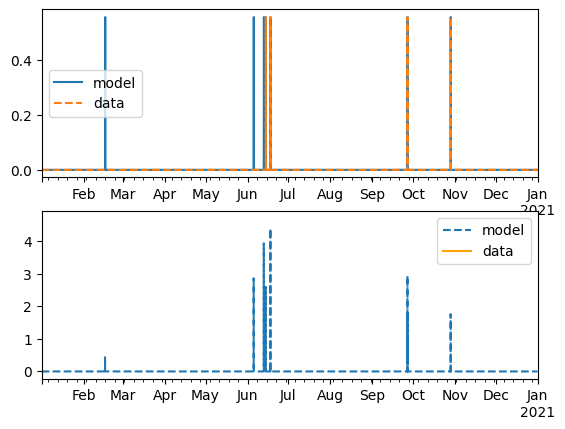

In [12]:
pump_data = pd.read_csv(
    "RTC/data/Dean Town Pump Data.csv",
    delimiter=",",
    index_col=0,
    parse_dates=True,
    names=pumps["name"],
    skiprows=1,
)
head_data = pd.read_csv(
    "RTC/data/Dean Town Head Data.csv",
    delimiter=",",
    index_col=0,
    parse_dates=True,
    names=weirs["name"],
    skiprows=1,
)

pump_model = pd.read_excel(
    "RTC/data/pump_data_model_2.xlsx", index_col=0, parse_dates=True
)
pump_data.index = pd.to_datetime(pump_data.index, format='mixed', dayfirst=True)
cso_model = pd.read_excel(
    "RTC/data/cso_data_model_2.xlsx", index_col=0, parse_dates=True
)

fig, ax = plt.subplots(2, 1)
pump_model['total_inflow'].plot(ax=ax[0], label='model')
pump_data['CSO_pump_2'].plot(ax=ax[0], ls='--', label='data')
# ax[0].plot(pump_model["total_inflow"].values, label="model")
# ax[0].plot(pump_data["CSO_pump_2"].values, ls="--", label="data")
ax[0].legend()

cso_model['total_inflow'].plot(ax=ax[1], ls='--', label='model')
ax[1].plot(
    weir_formula(1.34675, 21.8, head_data["CSO_2"].values, 10.27), label="data", c='orange'
)

# ax[1].plot(cso_model["total_inflow"].values, ls="--", label='model')
ax[1].legend()

In [14]:
pump_model

,total_inflow
2020-01-01 00:30:00,0.0
2020-01-01 00:45:00,0.0
2020-01-01 01:00:00,0.0
2020-01-01 01:15:00,0.0
2020-01-01 01:30:00,0.0
...,...
2020-12-31 23:00:00,0.0
2020-12-31 23:15:00,0.0
2020-12-31 23:30:00,0.0
2020-12-31 23:45:00,0.0


<Axes: >

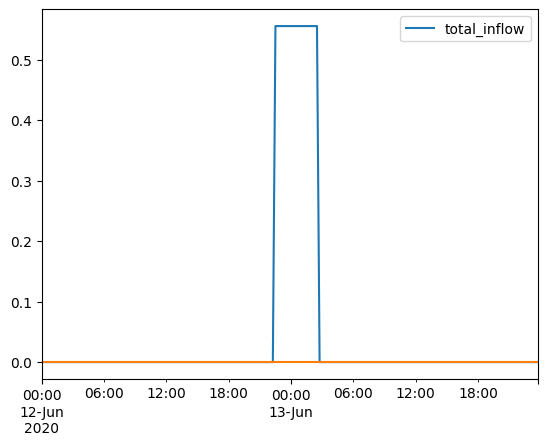

In [54]:
pump_model.loc['06-12-2020':'06-13-2020'].plot()
pump_data['CSO_pump_2'].loc['06-12-2020':'06-13-2020'].plot()

C:\Users\Jip\AppData\Local\Temp\ipykernel_7972\3788619159.py:2: RuntimeWarning: invalid value encountered in power
  return C * L * (h - z) ** (3 / 2)


<Axes: >

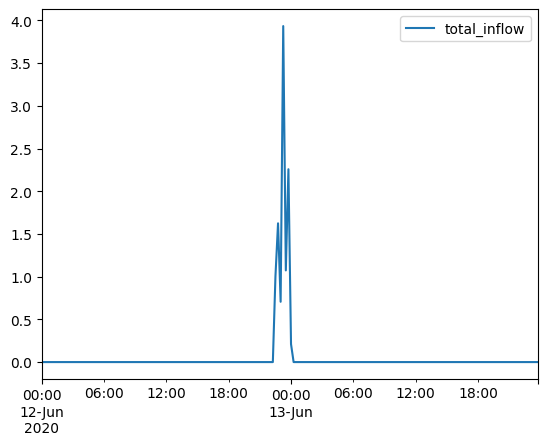

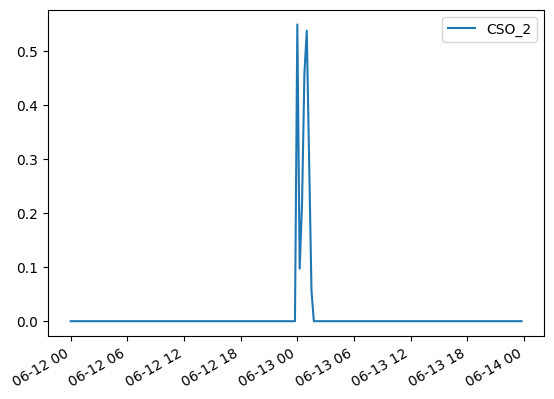

In [53]:
cso_model.loc['06-12-2020':'06-13-2020'].plot()
cso_data = pd.DataFrame()
cso_data['CSO_2'] = head_data["CSO_2"]
cso_data['CSO_2'] = weir_formula(1.34675, 21.8, head_data["CSO_2"].values, 10.27)
cso_data = cso_data.fillna(0)
cso_data.index = pd.to_datetime(cso_data.index, format='mixed')
cso_data.loc['06-12-2020':'06-13-2020'].plot()
